# Lockman-SWIRE Selection Functions
## Depth maps and selection functions for Lockman-SWIRE

The simplest selection function available is the field MOC which specifies the area for which there is Herschel data. Each pristine catalogue also has a MOC defining the area for which that data is available.

The next stage is to provide mean flux standard deviations which act as a proxy for the catalogue's 5$\sigma$ depth

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

In [2]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_lockman-swire_{}.fits".format(SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Diagnostics done using: {}".format(master_catalogue_filename))

ORDER = 10
#TODO write code to decide on appropriate order

field_moc = MOC(filename="../../dmu2/dmu2_field_coverages/Lockman-SWIRE_MOC.fits")


Diagnostics done using: master_catalogue_lockman-swire_20171201.fits


Plotting a histogram of magnitudes gives a quick idea of depth. 

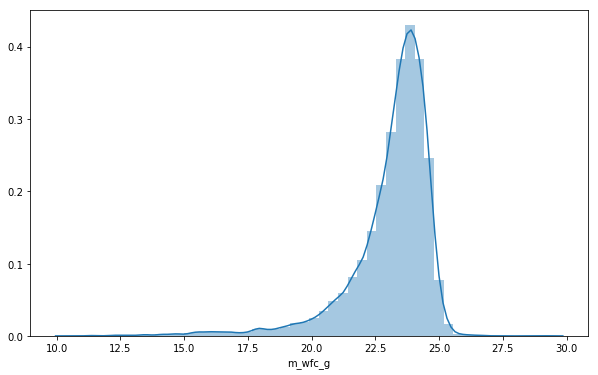

In [3]:
sns.distplot(master_catalogue['m_wfc_g'][(master_catalogue['m_wfc_g'] > 0) &  (master_catalogue['m_wfc_g'] < 90.)])

and for flux

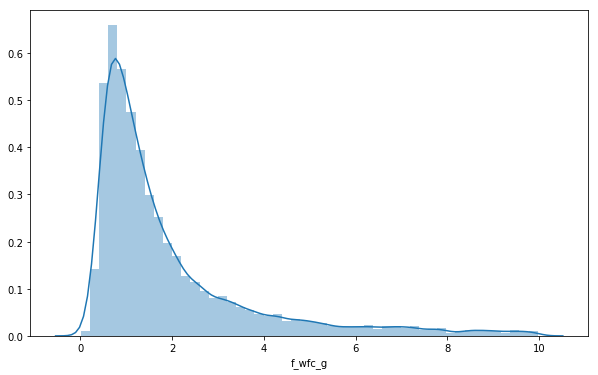

In [4]:
sns.distplot(master_catalogue['f_wfc_g'][(master_catalogue['f_wfc_g'] < 10.)  & (master_catalogue['f_wfc_g'] > 0)] )

Distribution of flux errors:

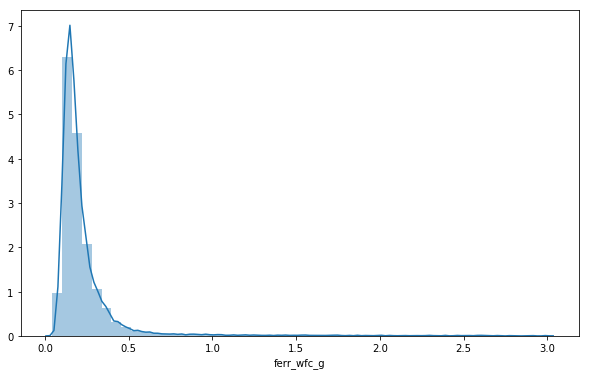

In [5]:
sns.distplot(master_catalogue['ferr_wfc_g'][(master_catalogue['ferr_wfc_g'] > 0.) &(master_catalogue['ferr_wfc_g'] < 3.)])

Magnitude error as function of magnitude

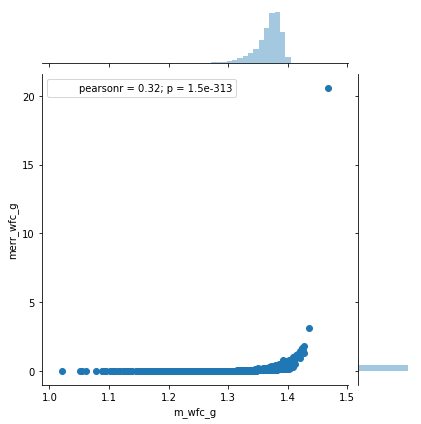

In [6]:
ax = sns.jointplot((np.log10(master_catalogue['m_wfc_g'])),
              (master_catalogue['merr_wfc_g'] ))
#ax.set(xticklabels=)

## I - Group masterlist objects by healpix cell and calculate depths
We add a column to the masterlist catalogue for the target order healpix cell <i>per object</i>.

In [7]:
#Add a column to the catalogue with the order=ORDER hp_idx
master_catalogue.add_column(Column(data=coords_to_hpidx(master_catalogue['ra'],
                                                       master_catalogue['dec'],
                                                       ORDER), 
                                   name="hp_idx_O_{}".format(str(ORDER))
                                  )
                           )

In [8]:
# Convert catalogue to pandas and group by the order=ORDER pixel

group = master_catalogue.group_by(["hp_idx_O_{}".format(str(ORDER))])

In [9]:
f_wfc_g_p90 = group["hp_idx_O_{}".format(str(ORDER)), 'f_wfc_g'].groups.aggregate(lambda x: np.nanpercentile(x, 10.))
f_wfc_g_p90['f_wfc_g'].name = 'f_wfc_g_p90'
f_wfc_g_p90[:10].show_in_notebook()

idx,hp_idx_O_10,f_wfc_g_p90
0,1547095,nan
1,1547099,nan
2,1547100,nan
3,1547101,nan
4,1547102,nan
5,1547103,nan
6,1547121,nan
7,1547123,nan
8,1547124,nan
9,1547125,nan


In [10]:
ferr_wfc_g_mean = group["hp_idx_O_{}".format(str(ORDER)), 'ferr_wfc_g'].groups.aggregate(np.nanmean)
ferr_wfc_g_mean['ferr_wfc_g'].name = 'ferr_wfc_g_mean'
ferr_wfc_g_mean[:10].show_in_notebook()

idx,hp_idx_O_10,ferr_wfc_g_mean
0,1547095,nan
1,1547099,nan
2,1547100,nan
3,1547101,nan
4,1547102,nan
5,1547103,nan
6,1547121,nan
7,1547123,nan
8,1547124,nan
9,1547125,nan


In [11]:
#Downgrade the groups from order=ORDER to order=13 and then fill out the appropriate cells
#hp.pixelfunc.ud_grade([2599293, 2599294], nside_out=hp.order2nside(13))

## II Create a table of all Order=13 healpix cells in the field and populate it
We create a table with every order=13 healpix cell in the field MOC. We then calculate the healpix cell at lower order that the order=13 cell is in. We then fill in the depth at every order=13 cell as calculated for the lower order cell that that the order=13 cell is inside.

In [12]:
depths = Table()
depths['hp_idx_O_13'] = list(field_moc.flattened(13))

In [13]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13
0,122683392
1,122683393
2,122683394
3,122683395
4,122683396
5,122683397
6,122683398
7,122683399
8,122683400
9,122683401


In [14]:
depths.add_column(Column(hp.pixelfunc.ang2pix(2**ORDER,
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[0],
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[1],
                     nest = True),
                  name="hp_idx_O_{}".format(str(ORDER))
                        )
                 )
                    

In [15]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10
0,122683392,1916928
1,122683393,1916928
2,122683394,1916928
3,122683395,1916928
4,122683396,1916928
5,122683397,1916928
6,122683398,1916928
7,122683399,1916928
8,122683400,1916928
9,122683401,1916928


In [ ]:
join(depths, ferr_wfc_g_mean)[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10,ferr_wfc_g_mean
0,99014137,1547095,nan
1,99014134,1547095,nan
2,99014133,1547095,nan
3,99014132,1547095,nan
4,99014131,1547095,nan
5,99014129,1547095,nan
6,99014128,1547095,nan
7,99014127,1547095,nan
8,99014126,1547095,nan
9,99014125,1547095,nan


In [ ]:
for col in master_catalogue.colnames:
    if col.startswith("f_"):
        errcol = "ferr{}".format(col[1:])
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), errcol].groups.aggregate(np.nanmean),
                     join_type='left')
        depths[errcol].name = errcol + "_mean"
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), col].groups.aggregate(lambda x: np.nanpercentile(x, 90.)),
                     join_type='left')
        depths[col].name = col + "_p90"

depths[:10].show_in_notebook()

## III - Save the table of depth maps

In [ ]:
depths.write("{}/depths_lockman-swire{}.fits".format(OUT_DIR, SUFFIX))